In [20]:
import os
import glob
import xarray as xr
import numpy as np
import cftime
import matplotlib.pyplot as plt

from osprey.actions.forecaster import forecaster_EOF_winter
from osprey.utils.folders import folders
from osprey.means.eof import preproc_pattern_3D, preproc_timeseries_3D
from osprey.utils.time import get_year, get_startleg
from osprey.means.means import timemean
from osprey.actions.reader import elements

In [13]:
expname = "lfr0"
var = "thetao"
ndim ="3D"
endleg = 200
yearspan = 10
yearleap = 10
dirs = folders(expname)

In [15]:
startleg = get_startleg(endleg, yearspan)
startyear = get_year(startleg)
endyear = get_year(endleg)
window = endyear - startyear + 1

In [3]:
rdata = forecaster_EOF_winter(expname, var, endleg, yearspan, yearleap)

File /ec/res4/scratch/itas/martini/lfr0/200/aux_data.nc not found.
Command: 'cdo cat /ec/res4/scratch/itas/ece4/lfr0/output/nemo/lfr0_oce_1m_T_2179-2179.nc /ec/res4/scratch/itas/ece4/lfr0/output/nemo/lfr0_oce_1m_T_2178-2178.nc /ec/res4/scratch/itas/martini/lfr0/200/aux_data.nc' 

/bin/sh: which: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `which'
/bin/sh: module: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `module'
/bin/sh: ml: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `ml'
cdi  warning (cdfScanVarAttr): NetCDF: Variable not found - >nav_lat_grid_T_inner<
cdi  warning (cdfScanVarAttr): NetCDF: Variable not found - >nav_lon_grid_T_inner<
cdi  warning (find_time_vars): Found more than one time variable, skipped variable time_centered!
cdi  warning (cdfInqContents): Coordinates variable time_centered can't be assigned!
cdi  warning (cdfSca

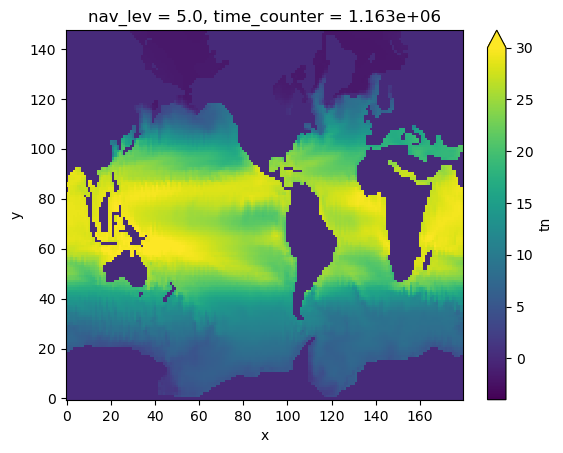

In [4]:
rdata['tn'].isel(nav_lev=0,time_counter=0).plot(vmin=-4,vmax=30)

In [5]:
filename = os.path.join(dirs['tmp'], str(endleg).zfill(3), f"{var}.nc")
data = xr.open_mfdataset(filename, use_cftime=True, preprocess=preproc_pattern_3D)
leg=199
filename = os.path.join(dirs['tmp'], str(leg).zfill(3), "lfr0_*_restart.nc")
sdata = xr.open_mfdataset(filename, use_cftime=True)

In [6]:
data['time'].values

array([cftime.DatetimeGregorian(2179, 1, 1, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(2180, 1, 1, 12, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(2180, 12, 31, 12, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(2182, 1, 1, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(2183, 1, 1, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(2184, 1, 1, 12, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(2184, 12, 31, 12, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(2186, 1, 1, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(2187, 1, 1, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(2188, 1, 1, 12, 0, 0, 0, has_year_zero=False)],
      dtype=object)

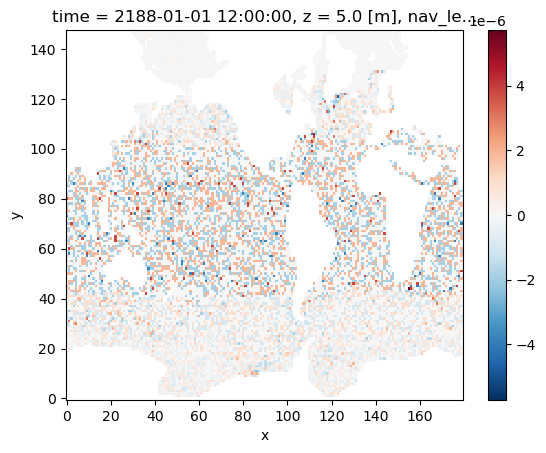

In [7]:
delta = data[var].isel(time=-1,z=0)-rdata['tn'].isel(time_counter=0,nav_lev=0)
delta.plot()

In [8]:
leg=199
filename = os.path.join(dirs['tmp'], str(leg).zfill(3), "lfr0_*_restart.nc")
sdata = xr.open_mfdataset(filename, use_cftime=True)

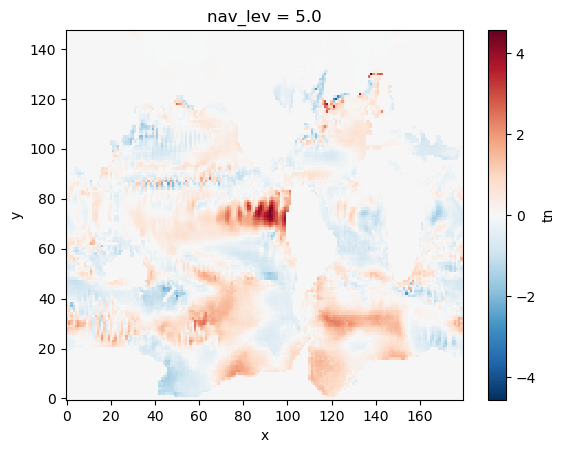

In [9]:
delta=sdata['tn'].isel(time_counter=0,nav_lev=0)-rdata['tn'].isel(time_counter=0,nav_lev=0)
delta.plot()

In [10]:
delta = rdata['tn']-sdata['tn']
delta

<xarray.DataArray 'tn' (time_counter: 0, nav_lev: 31, y: 148, x: 180)> Size: 0B
dask.array<sub, shape=(0, 31, 148, 180), dtype=float64, chunksize=(0, 1, 135, 180), chunktype=numpy.ndarray>
Coordinates:
  * nav_lev       (nav_lev) float32 124B 5.0 15.0 25.0 ... 4.75e+03 5.25e+03
  * time_counter  (time_counter) float32 0B 
    lon           (y, x) float32 107kB -1.0 -1.0 -1.0 -1.0 ... -1.0 -1.0 -1.0
    lat           (y, x) float32 107kB -1.0 -1.0 -1.0 -1.0 ... -1.0 -1.0 -1.0
Dimensions without coordinates: y, x

In [18]:
filename = os.path.join(dirs['tmp'], str(endleg).zfill(3), f"{var}_pattern.nc")
pattern = xr.open_mfdataset(filename, use_cftime=True, preprocess=preproc_pattern_3D)
field = pattern.isel(time=0)*0
for i in range(window):
    filename = os.path.join(dirs['tmp'], str(endleg).zfill(3), f"{var}_series_0000{i}.nc")    
    timeseries = xr.open_mfdataset(filename, use_cftime=True, preprocess=preproc_timeseries_3D)
    #p = timeseries.polyfit(dim='time', deg=1, skipna = True)
    # theta = xr.polyval(xf, p[f"{var}_polyfit_coefficients"])
    theta = timeseries[var].isel(time=-1)
    basis = pattern.isel(time=i)
    field = field + theta*basis
field = field.drop_vars({'time'})
filename = os.path.join(dirs['tmp'], str(endleg).zfill(3), f"{var}.nc")
xdata = xr.open_mfdataset(filename, use_cftime=True, preprocess=preproc_pattern_3D)
ave = timemean(xdata, var)
total = field + ave

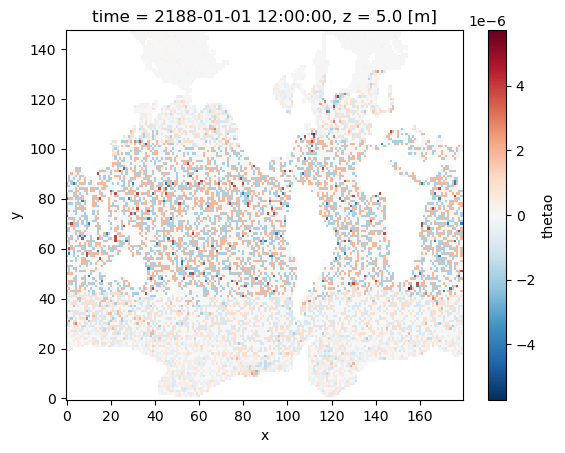

In [19]:
delta = xdata[var].isel(time=-1,z=0)-total[var].isel(z=0)
delta.plot()

In [21]:
df = elements(expname)
rpa = xdata[var].isel(time=-1).weighted(df['S']).mean(dim=['y', 'x'])
fpa = total[var].weighted(df['S']).mean(dim=['y', 'x'])

Text(0, 0.5, 'T')

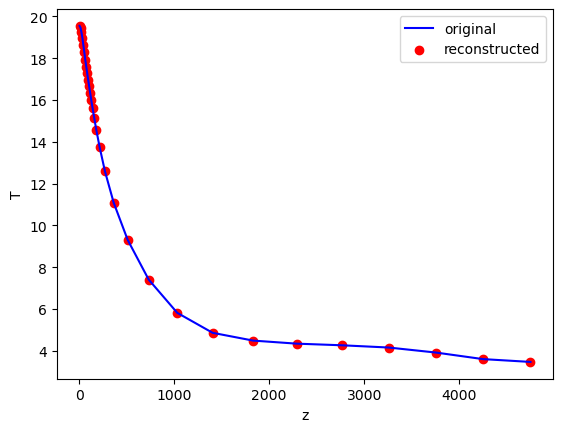

In [22]:
plt.plot(rpa['z'].values,fpa.values, color='b', label='original')
plt.scatter(fpa['z'].values,fpa.values, color='r', label='reconstructed')
plt.legend(loc="upper right")
plt.xlabel('z')
plt.ylabel('T')

Text(0, 0.5, 'T difference')

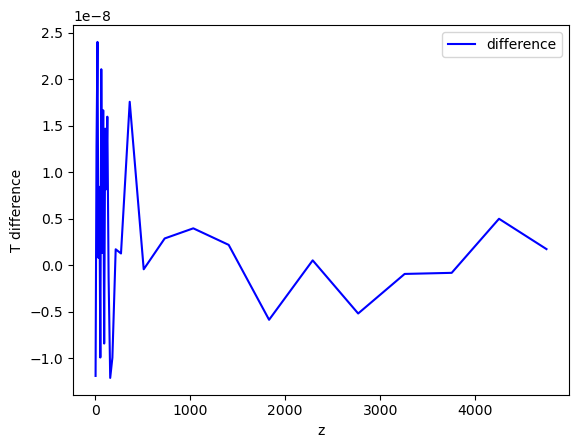

In [23]:
plt.plot(rpa['z'].values,rpa.values-fpa.values, color='b', label='difference')
plt.legend(loc="upper right")
plt.xlabel('z')
plt.ylabel('T difference')

In [26]:
filename

'/ec/res4/scratch/itas/martini/lfr0/199/FE00_*_restart.nc'

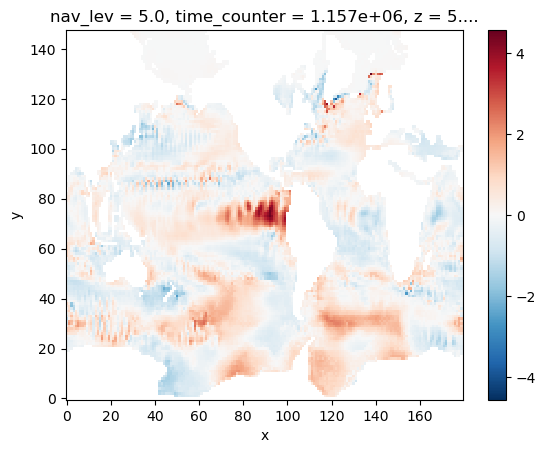

In [27]:
filename = os.path.join(dirs['tmp'], str(endleg-1).zfill(3), "lfr0_*_restart.nc")
rdata = xr.open_mfdataset(filename, use_cftime=True)
delta = rdata['tn'].isel(time_counter=0,nav_lev=0)-total[var].isel(z=0)
delta.plot()

In [28]:
rpa = rdata['tn'].isel(time_counter=0).weighted(df['S']).mean(dim=['y', 'x'])
fpa = total[var].weighted(df['S']).mean(dim=['y', 'x'])

Text(0, 0.5, 'T difference')

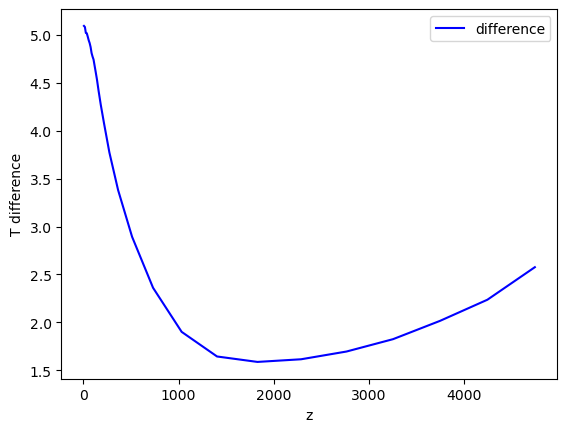

In [29]:
plt.plot(fpa['z'].values,fpa.values-rpa.values, color='b', label='difference')
plt.legend(loc="upper right")
plt.xlabel('z')
plt.ylabel('T difference')

In [28]:
# try the forecaster function

In [3]:
rdata = forecaster_EOF_winter(expname, var, endleg, yearspan, yearleap)

File /ec/res4/scratch/itas/martini/FE00/010/aux_data.nc not found.
Command: 'cdo cat /ec/res4/scratch/itas/ece4/FE00/output/nemo/FE00_oce_1m_T_1994-1994.nc /ec/res4/scratch/itas/ece4/FE00/output/nemo/FE00_oce_1m_T_1993-1993.nc /ec/res4/scratch/itas/martini/FE00/010/aux_data.nc' 

/bin/sh: which: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `which'
/bin/sh: module: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `module'
/bin/sh: ml: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `ml'
cdi  warning (cdfScanVarAttr): NetCDF: Variable not found - >nav_lat_grid_T_inner<
cdi  warning (cdfScanVarAttr): NetCDF: Variable not found - >nav_lon_grid_T_inner<
cdi  warning (find_time_vars): Found more than one time variable, skipped variable time_centered!
cdi  warning (cdfInqContents): Coordinates variable time_centered can't be assigned!
cdi  warning (cdfSca

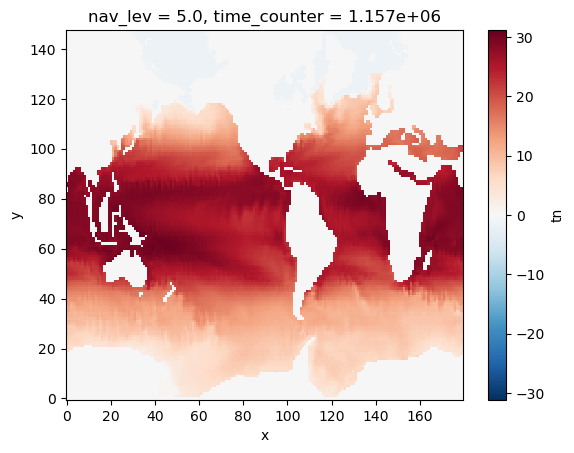

In [30]:
rdata['tn'].isel(time_counter=0,nav_lev=0).plot()

In [31]:
filename = os.path.join(dirs['tmp'], str(endleg).zfill(3), f"{var}.nc")
xdata = xr.open_mfdataset(filename, use_cftime=True, preprocess=preproc_pattern_3D)

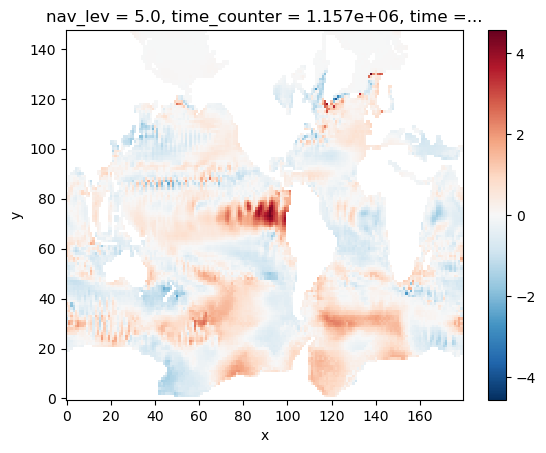

In [32]:
#delta = rdata['tn'].isel(time_counter=-1,nav_lev=0)-rrdata['tn'].isel(time_counter=-1,nav_lev=0)
delta = rdata['tn'].isel(time_counter=0,nav_lev=0)-xdata[var].isel(time=-1,z=0)
delta.plot()

In [6]:
# try the entire procedure from command line, load only the restart files

In [7]:
# we can try to reconstruct the restart, by projecting thetao six months in the future (do the same thing for the FIT procedure!)
# or maybe try with another thetao field in the future...

In [41]:
# using fit to reconstruct year 1999
fdate = cftime.DatetimeGregorian(1999, 1, 1, 0, 0, 0, has_year_zero=False)
xf = xr.DataArray(data = np.array([fdate]), dims = ['time'], coords = {'time': np.array([fdate])}, attrs = {'stardand_name': 'time', 'long_name': 'Time axis', 'bounds': 'time_counter_bnds', 'axis': 'T'})
filename = os.path.join(dirs['tmp'], str(endleg).zfill(3), f"{var}_pattern.nc")
pattern = xr.open_mfdataset(filename, use_cftime=True, preprocess=preproc_pattern_3D)
field = pattern.isel(time=0)*0
for i in range(window):
    filename = os.path.join(dirs['tmp'], str(endleg).zfill(3), f"{var}_series_0000{i}.nc")
    timeseries = xr.open_mfdataset(filename, use_cftime=True, preprocess=preproc_timeseries_3D)
    p = timeseries.polyfit(dim='time', deg=2, skipna = True)
    theta = xr.polyval(xf, p[f"{var}_polyfit_coefficients"])
    basis = pattern.isel(time=i)
    field = field + theta*basis
field = field.isel(time=0)
filename = os.path.join(dirs['tmp'], str(endleg).zfill(3), f"{var}.nc")
xdata = xr.open_mfdataset(filename, use_cftime=True, preprocess=preproc_pattern_3D)
ave = timemean(xdata, var)
total = field + ave

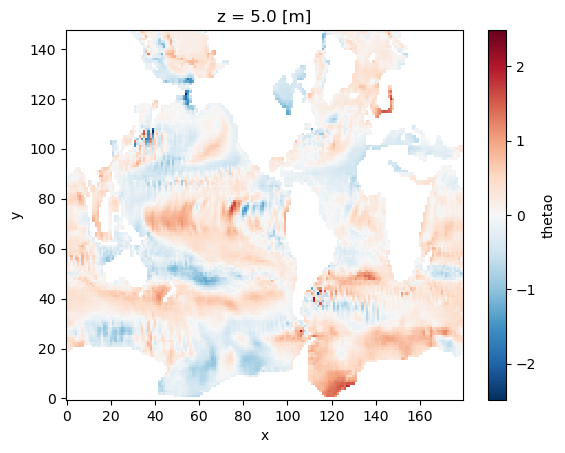

In [42]:
delta = xdata['thetao'].isel(time=-1,z=0) - total['thetao'].isel(z=0)
delta.plot()

Text(0, 0.5, 'T difference')

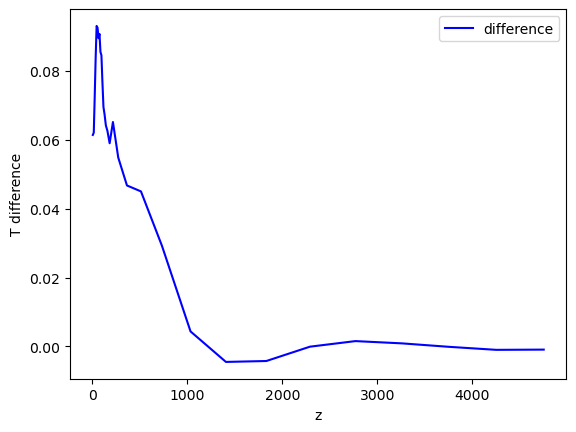

In [43]:
df = elements(expname)
rpa = xdata[var].isel(time=-1).weighted(df['S']).mean(dim=['y', 'x'])
fpa = total[var].weighted(df['S']).mean(dim=['y', 'x'])
plt.plot(rpa['z'].values,rpa.values-fpa.values, color='b', label='difference')
plt.legend(loc="upper right")
plt.xlabel('z')
plt.ylabel('T difference')

In [44]:
# using fit to reconstuct year 2000
fdate = cftime.DatetimeGregorian(2000, 1, 1, 0, 0, 0, has_year_zero=False)
xf = xr.DataArray(data = np.array([fdate]), dims = ['time'], coords = {'time': np.array([fdate])}, attrs = {'stardand_name': 'time', 'long_name': 'Time axis', 'bounds': 'time_counter_bnds', 'axis': 'T'})
filename = os.path.join(dirs['tmp'], str(endleg).zfill(3), f"{var}_pattern.nc")
pattern = xr.open_mfdataset(filename, use_cftime=True, preprocess=preproc_pattern_3D)
field = pattern.isel(time=0)*0
for i in range(window):
    filename = os.path.join(dirs['tmp'], str(endleg).zfill(3), f"{var}_series_0000{i}.nc")
    timeseries = xr.open_mfdataset(filename, use_cftime=True, preprocess=preproc_timeseries_3D)
    timeseries[var] = timeseries[var].astype(np.float64)
    p = timeseries.polyfit(dim='time', deg=8, skipna = True)
    theta = xr.polyval(xf, p[f"{var}_polyfit_coefficients"])
    basis = pattern.isel(time=i)
    field = field + theta*basis
field = field.isel(time=0)
filename = os.path.join(dirs['tmp'], str(endleg).zfill(3), f"{var}.nc")
xdata = xr.open_mfdataset(filename, use_cftime=True, preprocess=preproc_pattern_3D)
ave = timemean(xdata, var)
total = field + ave

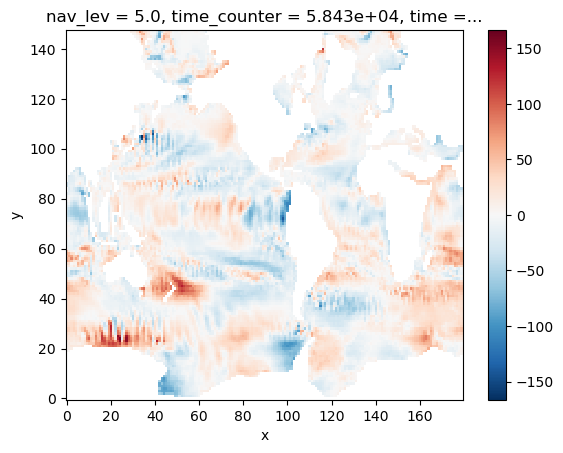

In [45]:
filename = os.path.join(dirs['tmp'], str(endleg+1).zfill(3), "FE00_*_restart.nc")
rdata = xr.open_mfdataset(filename, use_cftime=True)
delta = rdata['tn'].isel(time_counter=0,nav_lev=0)-total[var].isel(z=0)
delta.plot()

Text(0, 0.5, 'T difference')

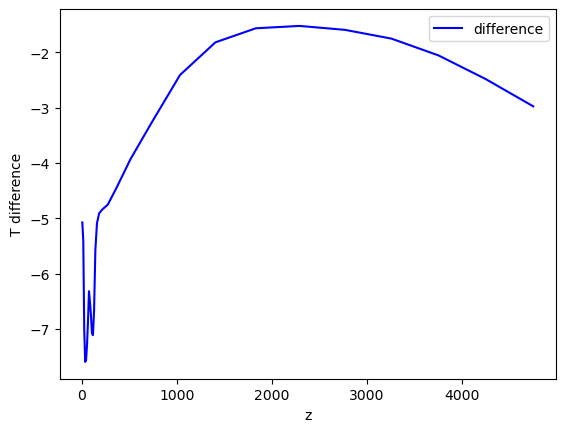

In [46]:
df = elements(expname)
rpa = rdata['tn'].isel(time_counter=0).weighted(df['S']).mean(dim=['y', 'x'])
fpa = total[var].weighted(df['S']).mean(dim=['y', 'x'])
plt.plot(fpa['z'].values,rpa.values-fpa.values, color='b', label='difference')
plt.legend(loc="upper right")
plt.xlabel('z')
plt.ylabel('T difference')